# Классификация Oxford Pets

Импортируем необходимые библиотеки

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

Установим сид в функции `random` и сконфигурируем устройство (`cpu` либо `gpu`)

In [69]:
SEED = 2904
np.random.seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)
DEVICE = 'cpu'
img_size = 256, 256
batch_size = 64

## Обработка входных данных

### Загрузка датасета

[Датасет](https://www.kaggle.com/datasets/tanlikesmath/the-oxfordiiit-pet-dataset) загрузили вручную и распаковали архив в папку dataset

In [70]:
images = os.listdir('dataset/images/')

Теперь определим классы датасета

In [71]:
def get_class(string):
    for i, ch in enumerate(string):
        if ch.isdigit():
            return string[:i-1]
        
classes = list(set([get_class(img) for img in images if get_class(img) is not None]))

### Разделение на обучающую и тестовую выборки

In [72]:
os.makedirs('dataset/train/')
os.makedirs('dataset/val/')
val_size = 0.2

for cl in classes:
    os.makedirs(os.path.join('dataset/train/', cl))
    os.makedirs(os.path.join('dataset/val/', cl))

for i, image in enumerate(images):
    cur_class = get_class(image)
    if cur_class is None:
        continue
    if np.random.random(1) < 1 - val_size:
        shutil.copy(os.path.join('dataset/images', image), os.path.join('dataset/train', cur_class))
    else:
        shutil.copy(os.path.join('dataset/images', image), os.path.join('dataset/val', cur_class))

In [73]:
transform = transforms.Compose([
                                transforms.Resize(img_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

train = datasets.ImageFolder('dataset/train', transform=transform)
val = datasets.ImageFolder('dataset/val', transform=transform)

Сделаем даталоадеры

In [74]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)

## Обучение моделей

In [75]:
def train_model(model, train_loader, test_loader, epochs_num, optimizer, criterion, device):
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []

    for _ in range(epochs_num):
        cur_train_acc = 0
        cur_test_acc = 0
        cur_train_loss = 0
        cur_test_loss = 0
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            cur_train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cur_train_acc += (y_batch.squeeze() == torch.argmax(y_pred, axis=1)).cpu().numpy().sum()
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                y_pred = model(X_batch)
                cur_test_acc += (y_batch.squeeze() == torch.argmax(y_pred, axis=1)).cpu().numpy().sum()
                loss = criterion(y_pred, y_batch)
                cur_test_loss += loss.cpu().item()
        train_acc_history.append(cur_train_acc / (len(train_loader) * batch_size))
        test_acc_history.append(cur_test_acc / (len(test_loader) * batch_size))
        train_loss_history.append(cur_train_loss / (len(train_loader) * batch_size))
        test_loss_history.append(cur_test_loss / (len(test_loader) * batch_size))
    return train_loss_history, test_loss_history, train_acc_history, test_acc_history

In [76]:
def plot_loss(train_loss, test_loss):
    plt.figure(figsize=(10, 10))
    plt.title("Loss")
    plt.plot(range(1, len(train_loss) + 1), train_loss, linewidth=2, label='train loss')
    plt.plot(range(1, len(test_loss) + 1), test_loss, linewidth=2, label='test loss')
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [77]:
def plot_acc(train_acc, test_acc):
    plt.figure(figsize=(10, 10))
    plt.title("Accuracy")
    plt.plot(range(1, len(train_acc) + 1), train_acc, linewidth=2, label='train accuracy')
    plt.plot(range(1, len(test_acc) + 1), test_acc, linewidth=2, label='test accuracy')
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

## Модель VGG16

In [78]:
vgg = models.vgg16(pretrained=True)

In [79]:
vgg.classifier[-1] = nn.Linear(4096, len(classes))

vgg = vgg.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=1e-4)

epochs = 5

In [80]:
train_loss, test_loss, train_acc, test_acc = train_model(vgg, 
                                                         train_loader, 
                                                         val_loader, 
                                                         epochs, 
                                                         optimizer, 
                                                         criterion, 
                                                         DEVICE)

#### VGG16 Accuracy

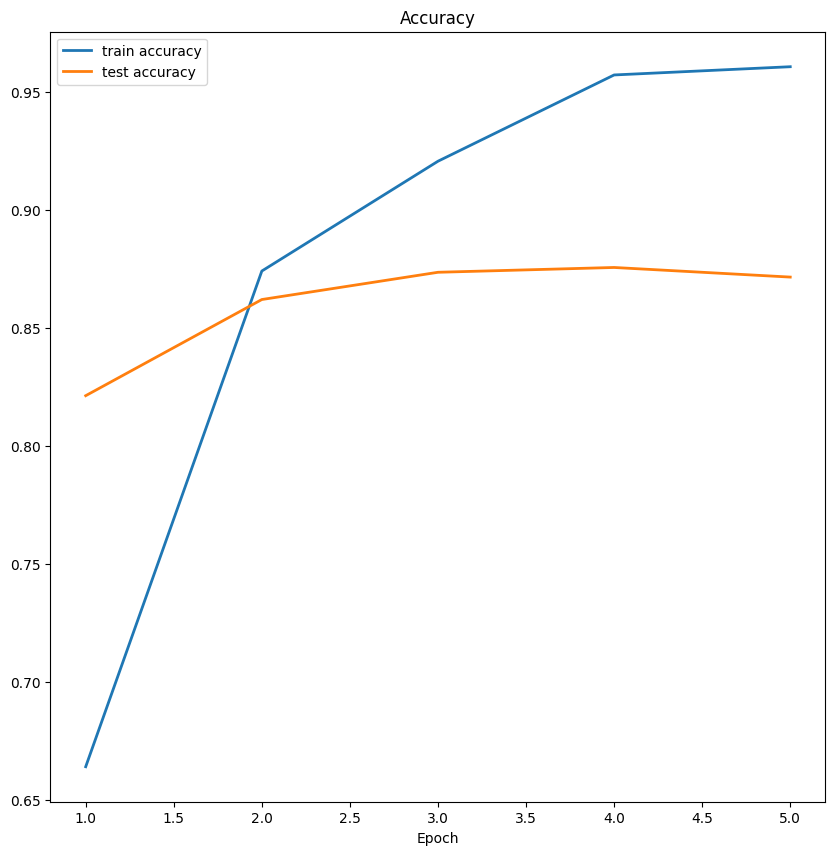

In [81]:
plot_acc(train_acc, test_acc)

#### VGG16 Loss

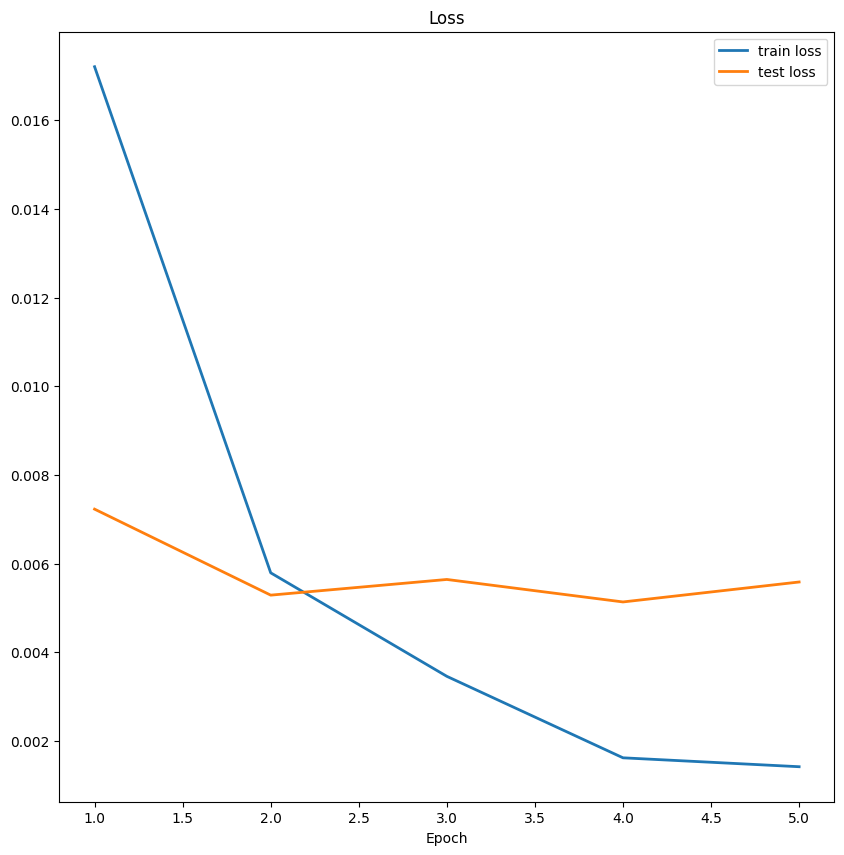

In [82]:
plot_loss(train_loss, test_loss)

**Точность VGG16**

In [83]:
train_acc[-1]

0.9607712765957447

## Модель ResNet18

In [84]:
resnet = models.resnet18(pretrained=True)

C:\Users\boris\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\boris/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [85]:
resnet.fc = nn.Linear(512, len(classes))

resnet = resnet.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

epochs = 5

In [86]:
train_loss, test_loss, train_acc, test_acc = train_model(resnet, 
                                                         train_loader, 
                                                         val_loader, 
                                                         epochs, 
                                                         optimizer, 
                                                         criterion, 
                                                         DEVICE)

#### ResNet Accuracy

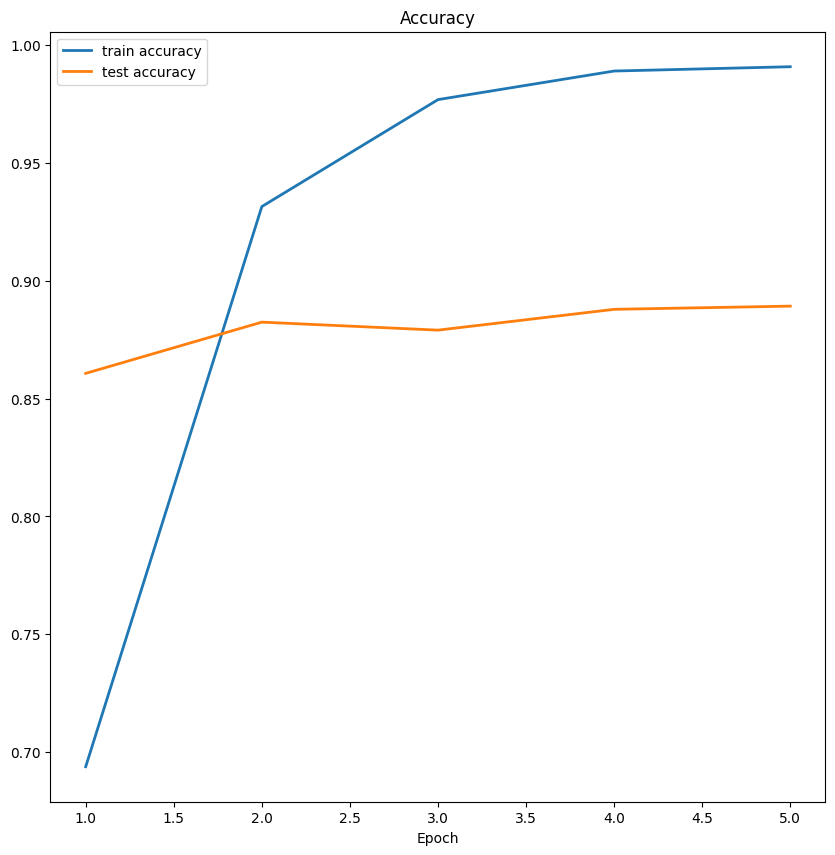

In [87]:
plot_acc(train_acc, test_acc)

#### ResNet Loss

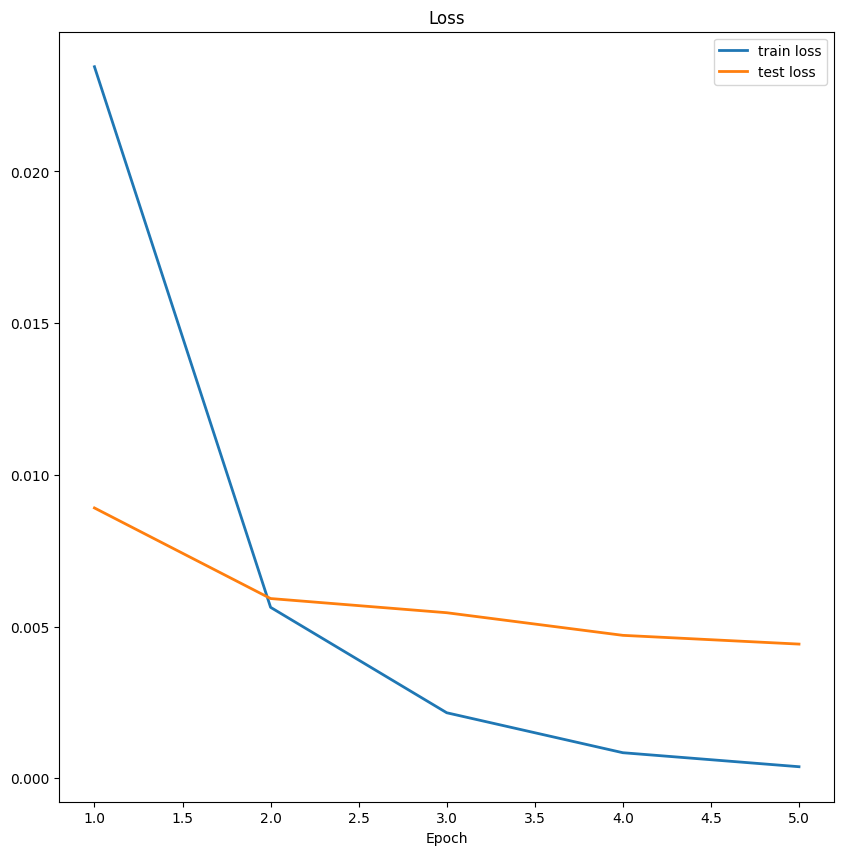

In [88]:
plot_loss(train_loss, test_loss)

**Точность ResNet**

In [89]:
train_acc[-1]

0.9908577127659575

### Confusion Matrix для ResNet

In [90]:
def plot_confusion_matrix(model, test_loader):
    preds = None
    reals = None
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            y_pred = model(X_batch)
            if preds is None:
                preds = torch.argmax(y_pred, axis=1).cpu().numpy()
                reals = y_batch.cpu().numpy()
            else:
                preds = np.hstack([preds, torch.argmax(y_pred, axis=1).cpu().numpy()])
                reals = np.hstack([reals, y_batch.cpu().numpy()])
    cm = confusion_matrix(reals, preds)
    df_cm = pd.DataFrame(cm, index = [i for i in classes], columns = [i for i in classes])
    plt.figure(figsize = (15, 15))
    sns.heatmap(df_cm, annot=True)
    plt.show()

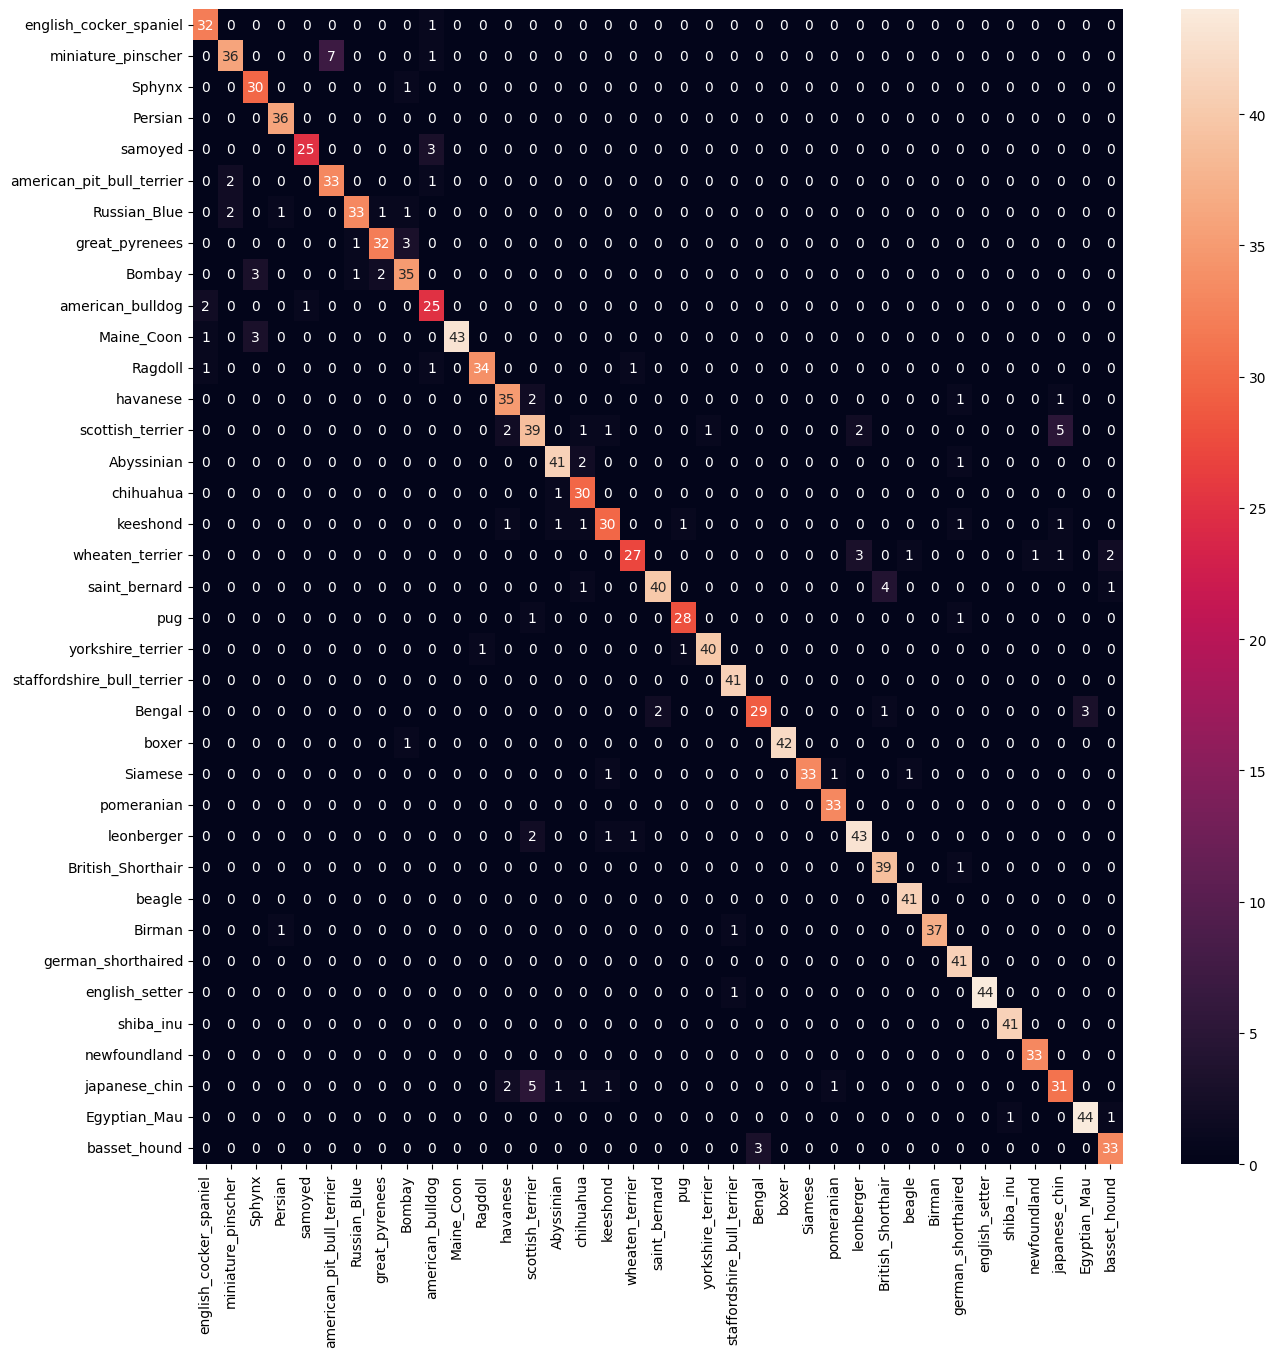

In [91]:
plot_confusion_matrix(resnet, val_loader)